In [1]:
import os
os.chdir('/home/xinglong/git_local/dynamax/')

import matplotlib.pyplot as plt

In [2]:
import jax.numpy as jnp
import jax.random as jr
from jax import lax

from dynamax.structural_time_series.models.sts_model import StructuralTimeSeries as STS
from dynamax.structural_time_series.models.sts_components import *

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.distributions import (
    MultivariateNormalFullCovariance as MVN
)

Test LocalLinearTrend forecast

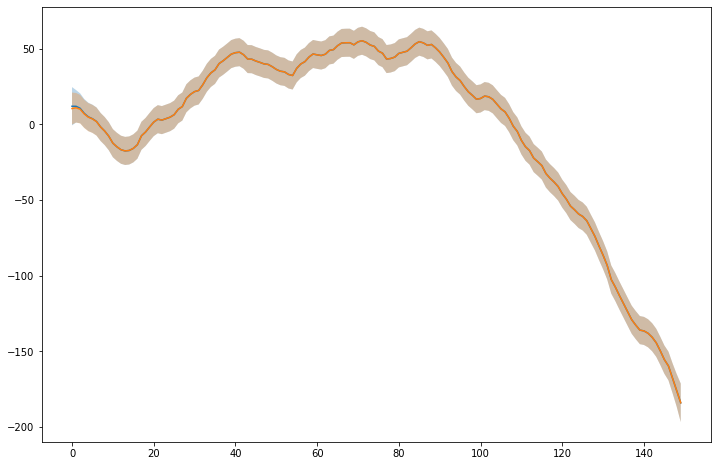

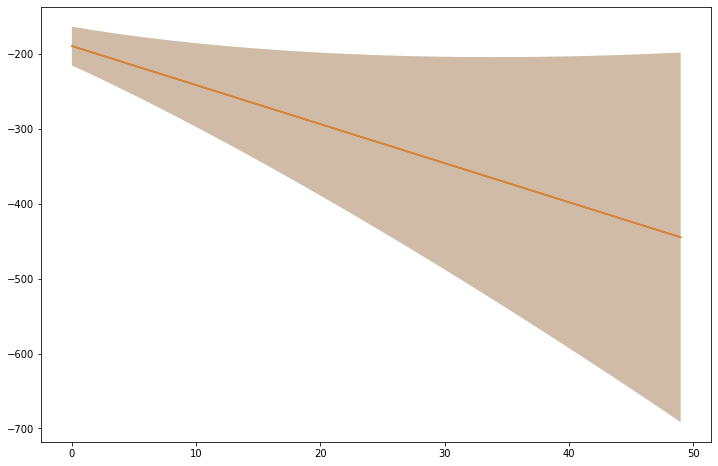

In [109]:
def _build_models(time_steps, key):
    
    keys = jr.split(key, 5)
    standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

    # Generate parameters of the STS component
    level_scale = 5
    slope_scale = 0.5
    initial_level = standard_mvn.sample(seed=keys[0])
    initial_slope = standard_mvn.sample(seed=keys[1])

    obs_noise_scale = 10

    # Generate observed time series using the SSM representation.
    F = jnp.array([[1, 1],
                   [0, 1]])
    H = jnp.array([[1, 0]])
    Q = jnp.block([[level_scale, 0],
                   [0, slope_scale]])
    R = obs_noise_scale

    def _step(current_state, key):
        key1, key2 = jr.split(key)
        current_obs = H @ current_state + R * standard_mvn.sample(seed=key1)
        next_state = F @ current_state + Q @ MVN(jnp.zeros(2), jnp.eye(2)).sample(seed=key2)
        return next_state, current_obs

    initial_state = jnp.concatenate((initial_level, initial_slope))
    key_seq = jr.split(keys[2], time_steps)
    _, obs_time_series = lax.scan(_step, initial_state, key_seq)

    # Build the STS model using tfp module.
    tfp_comp = tfp.sts.LocalLinearTrend(observed_time_series=obs_time_series, name='local_linear_trend')
    tfp_model = tfp.sts.Sum([tfp_comp], observed_time_series=obs_time_series, constant_offset=0.)

    # Build the dynamax STS model.
    dynamax_comp = LocalLinearTrend(name='local_linear_trend')
    dynamax_model = STS([dynamax_comp], obs_time_series=obs_time_series)

    # Set the parameters to the parameters learned by the tfp module and fix the parameters.
    tfp_vi_posterior = tfp.sts.build_factored_surrogate_posterior(tfp_model)
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=tfp_model.joint_distribution(obs_time_series).log_prob,
        surrogate_posterior=tfp_vi_posterior,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=200,
        jit_compile=True)
    vi_dists, _ = tfp_vi_posterior.distribution.sample_distributions()
    tfp_params = tfp_vi_posterior.sample(sample_shape=(1,))

    dynamax_model.params['local_linear_trend']['cov_level'] =\
        jnp.atleast_2d(jnp.array(tfp_params['local_linear_trend/_level_scale']**2))
    dynamax_model.params['local_linear_trend']['cov_slope'] =\
        jnp.atleast_2d(jnp.array(tfp_params['local_linear_trend/_slope_scale']**2))
    dynamax_model.params['obs_model']['cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['observation_noise_scale']**2))

    return (tfp_model, tfp_params,
            dynamax_model, dynamax_model.params,
            obs_time_series,
            vi_dists)


time_steps=150
key=jr.PRNGKey(3)
    
tfp_model, tfp_params, dynamax_model, dynamax_params, obs_time_series, vi_dists =\
    _build_models(time_steps, key)

# Fit and forecast with the tfp module.
# Not use tfp.sts.decmopose_by_component() since its output series is centered at 0.
masked_time_series = tfp.sts.MaskedTimeSeries(time_series=obs_time_series,
                                              is_missing=tf.math.is_nan(obs_time_series))
tfp_posterior = tfp.sts.impute_missing_values(tfp_model, masked_time_series, tfp_params,
                                              include_observation_noise=False)
tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                 parameter_samples=tfp_params,
                                 num_steps_forecast=50,
                                 include_observation_noise=True)
tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

# Fit and forecast with dynamax
dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                         obs_time_series)
dynamax_forecast = dynamax_model.forecast(dynamax_params, obs_time_series,
                                          num_forecast_steps=50)
dynamax_posterior_mean = dynamax_posterior['local_linear_trend']['pos_mean'].squeeze()
dynamax_posterior_cov = dynamax_posterior['local_linear_trend']['pos_cov'].squeeze()
dynamax_forecast_mean = dynamax_forecast['means'].squeeze()
dynamax_forecast_cov = dynamax_forecast['covariances'].squeeze()

# Compare posterior inference by tfp and dynamax.
# In comparing the smoothed posterior, we omit the first 5 time steps,
# since the tfp and the dynamax implementations of STS has different settings in
# distributions of initial state, which will influence the posterior inference of
# the first few states.
len_step = jnp.abs(tfp_posterior_mean[1:]-tfp_posterior_mean[:-1]).mean()
assert jnp.allclose(tfp_posterior_mean[5:], dynamax_posterior_mean[5:], atol=len_step)
assert jnp.allclose(tfp_posterior_scale[5:], jnp.sqrt(dynamax_posterior_cov)[5:], rtol=1e-1)
# Compoare forecast by tfp and dynamax.
assert jnp.allclose(tfp_forecast_mean, dynamax_forecast_mean, atol=0.5*len_step)
assert jnp.allclose(tfp_forecast_scale, jnp.sqrt(dynamax_forecast_cov), rtol=5e-2)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_posterior_mean)
ax.plot(dynamax_posterior_mean)
ax.fill_between(jnp.arange(150),
                 tfp_posterior_mean-2*tfp_posterior_scale,
                 tfp_posterior_mean+2*tfp_posterior_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(150),
                 dynamax_posterior_mean-2*jnp.sqrt(dynamax_posterior_cov),
                 dynamax_posterior_mean+2*jnp.sqrt(dynamax_posterior_cov),
                 alpha=0.3)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_forecast_mean)
ax.plot(dynamax_forecast_mean)
ax.fill_between(jnp.arange(50),
                 tfp_forecast_mean-2*tfp_forecast_scale,
                 tfp_forecast_mean+2*tfp_forecast_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(50),
                 dynamax_forecast_mean-2*jnp.sqrt(dynamax_forecast_cov),
                 dynamax_forecast_mean+2*jnp.sqrt(dynamax_forecast_cov),
                 alpha=0.3)


Test Autoregressive forecast

In [89]:
def _build_models(time_steps, key):
    
    keys = jr.split(key, 5)
    standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

    # Generate parameters of the STS component
    level_scale = 5.
    coef = 0.8
    initial_level = standard_mvn.sample(seed=keys[0])

    obs_noise_scale = 4.

    # Generate observed time series using the SSM representation.
    F = jnp.array([[coef]])
    H = jnp.array([[1]])
    Q = jnp.array([[level_scale]])
    R = obs_noise_scale

    def _step(current_state, key):
        key1, key2 = jr.split(key)
        current_obs = H @ current_state + R * standard_mvn.sample(seed=key1)
        next_state = F @ current_state + Q @ MVN(jnp.zeros(1), jnp.eye(1)).sample(seed=key2)
        return next_state, (H @ current_state, current_obs)

    initial_state = initial_level
    key_seq = jr.split(keys[2], time_steps)
    _, (obs_mean, obs_time_series) = lax.scan(_step, initial_state, key_seq)

    # Build the STS model using tfp module.
    tfp_comp = tfp.sts.Autoregressive(order=1, observed_time_series=obs_time_series, name='ar')
    tfp_model = tfp.sts.Sum([tfp_comp], observed_time_series=obs_time_series, constant_offset=0.)

    # Build the dynamax STS model.
    dynamax_comp = Autoregressive(order=1, name='ar')
    dynamax_model = STS([dynamax_comp], obs_time_series=obs_time_series)

    # Set the parameters to the parameters learned by the tfp module and fix the parameters.
    tfp_vi_posterior = tfp.sts.build_factored_surrogate_posterior(tfp_model)
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=tfp_model.joint_distribution(obs_time_series).log_prob,
        surrogate_posterior=tfp_vi_posterior,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=200,
        jit_compile=True)
    vi_dists, _ = tfp_vi_posterior.distribution.sample_distributions()
    tfp_params = tfp_vi_posterior.sample(sample_shape=(1,))

    dynamax_model.params['ar']['cov_level'] =\
        jnp.atleast_2d(jnp.array(tfp_params['ar/_level_scale']**2))
    dynamax_model.params['ar']['coef'] = jnp.array(tfp_params['ar/_coefficients'])[0]
    dynamax_model.params['obs_model']['cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['observation_noise_scale']**2))

    return (tfp_model, tfp_params,
            dynamax_model, dynamax_model.params,
            obs_mean,
            obs_time_series,
            vi_dists)


tfp_model, tfp_params, dynamax_model, dynamax_params, obs_mean, obs_time_series, vi_dists =\
        _build_models(time_steps, key)

masked_time_series = tfp.sts.MaskedTimeSeries(time_series=obs_time_series,
                                              is_missing=tf.math.is_nan(obs_time_series))
tfp_posterior = tfp.sts.impute_missing_values(tfp_model, masked_time_series, tfp_params,
                                              include_observation_noise=False)
tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                 parameter_samples=tfp_params,
                                 num_steps_forecast=50,
                                 include_observation_noise=True)
tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                         obs_time_series)
dynamax_forecast = dynamax_model.forecast(dynamax_params, obs_time_series,
                                          num_forecast_steps=50)
dynamax_posterior_mean = dynamax_posterior['ar']['pos_mean'].squeeze()
dynamax_posterior_cov = dynamax_posterior['ar']['pos_cov'].squeeze()
dynamax_forecast_mean = dynamax_forecast['means'].squeeze()
dynamax_forecast_cov = dynamax_forecast['covariances'].squeeze()


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_posterior_mean)
ax.plot(dynamax_posterior_mean)
ax.fill_between(jnp.arange(150),
                 tfp_posterior_mean-2*tfp_posterior_scale,
                 tfp_posterior_mean+2*tfp_posterior_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(150),
                 dynamax_posterior_mean-2*jnp.sqrt(dynamax_posterior_cov),
                 dynamax_posterior_mean+2*jnp.sqrt(dynamax_posterior_cov),
                 alpha=0.3)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_forecast_mean)
ax.plot(dynamax_forecast_mean)
ax.fill_between(jnp.arange(50),
                 tfp_forecast_mean-2*tfp_forecast_scale,
                 tfp_forecast_mean+2*tfp_forecast_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(50),
                 dynamax_forecast_mean-2*jnp.sqrt(dynamax_forecast_cov),
                 dynamax_forecast_mean+2*jnp.sqrt(dynamax_forecast_cov),
                 alpha=0.3)

Test LinearRegression forecast

In [184]:
def _build_models(time_steps, key):

    keys = jr.split(key, 5)
    standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

    # Generate covariates from an AR(1) model
    c0 = standard_mvn.sample(seed=keys[0])
    cf = jnp.array([[0.8]])
    cq = jnp.array([[5.]])

    def _step(c0, key):
        c1 = cf @ c0 + cq @ standard_mvn.sample(seed=key)
        return c1, c0
    _keys = jr.split(keys[1], time_steps + 50)
    _, covariates = lax.scan(_step, c0, _keys)

    weights = jnp.array([[5.], [0]]) + standard_mvn.sample(seed=keys[2], sample_shape=(2,))

    # Generate parameters of the STS component
    inputs = jnp.concatenate((covariates, jnp.ones((time_steps + 50, 1))), axis=1)
    obs_noise_scale = 6.

    # Generate observed time series.
    obs_mean = inputs[:time_steps] @ weights
    obs_time_series = obs_mean + obs_noise_scale*standard_mvn.sample(seed=keys[3],
                                                                     sample_shape=(time_steps,))

    # Build the STS model using tfp module.
    tfp_comp = tfp.sts.LinearRegression(inputs, name='linear_regression')
    tfp_model = tfp.sts.Sum([tfp_comp], observed_time_series=obs_time_series)

    # Build the dynamax STS model.
    dynamax_comp = LinearRegression(dim_covariates=1, name='linear_regression')
    dynamax_model = STS([dynamax_comp],
                        obs_time_series=obs_time_series, covariates=covariates[:time_steps])

    # Set the parameters to the parameters learned by the tfp module and fix the parameters.
    tfp_vi_posterior = tfp.sts.build_factored_surrogate_posterior(tfp_model)
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=tfp_model.joint_distribution(obs_time_series).log_prob,
        surrogate_posterior=tfp_vi_posterior,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=200,
        jit_compile=True)
    vi_dists, _ = tfp_vi_posterior.distribution.sample_distributions()
    tfp_params = tfp_vi_posterior.sample(sample_shape=(1,))

    dynamax_model.params['linear_regression']['weights'] =\
        jnp.atleast_2d(jnp.array(tfp_params['linear_regression/_weights'])).T
    dynamax_model.params['obs_model']['cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['observation_noise_scale']**2))

    return (tfp_model, tfp_params,
            dynamax_model, dynamax_model.params,
            covariates,
            obs_time_series,
            vi_dists)


In [185]:
tfp_model, tfp_params, dynamax_model, dynamax_params, covariates, obs_time_series, vi_dists =\
        _build_models(time_steps, key)
covariates_pre = covariates[:time_steps]
covariates_pos = covariates[time_steps:]

In [186]:
masked_time_series = tfp.sts.MaskedTimeSeries(time_series=obs_time_series,
                                              is_missing=tf.math.is_nan(obs_time_series))
tfp_posterior = tfp.sts.impute_missing_values(tfp_model, masked_time_series, tfp_params,
                                              include_observation_noise=False)

tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                 parameter_samples=tfp_params,
                                 num_steps_forecast=50,
                                 include_observation_noise=True)
tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

In [191]:
self = dynamax_model
params = self.params,
param_props = self.param_props,
param_priors = self.param_priors,
trans_mat_getters = self.trans_mat_getters,
trans_cov_getters = self.trans_cov_getters,
obs_mats = self.obs_mats,
cov_select_mats = self.cov_select_mats,
initial_distributions = self.initial_distributions,
reg_func = self.reg_func,
obs_distribution = self.obs_distribution,
dim_covariate = self.dim_covariate

In [193]:
import jax.scipy as jsp

params = params
param_props = param_props
param_priors = param_priors

trans_mat_getters = trans_mat_getters
trans_cov_getters = trans_cov_getters
component_obs_mats = obs_mats
cov_select_mats = cov_select_mats


In [195]:
cov_select_mats

(OrderedDict(),)

In [196]:

latent_comp_names = cov_select_mats.keys()
obs_distribution = obs_distribution


AttributeError: 'tuple' object has no attribute 'keys'

In [198]:

initial_mean = jnp.concatenate(
    [init_pri.mode() for init_pri in initial_distributions.values()])
initial_cov = jsp.linalg.block_diag(
    *[init_pri.covariance() for init_pri in initial_distributions.values()])


AttributeError: 'tuple' object has no attribute 'values'

In [200]:

obs_mat = jnp.concatenate([*obs_mats.values()], axis=1)
cov_select_mat = jsp.linalg.block_diag(*cov_select_mats.values())


AttributeError: 'tuple' object has no attribute 'values'

In [201]:

# Dimensions of the SSM.
dim_obs, self.dim_state = self.obs_mat.shape
dim_comp = self.get_trans_cov(self.params, 0).shape[0]
dim_covariate = dim_covariate

AttributeError: 'StructuralTimeSeries' object has no attribute 'obs_mat'

In [202]:
dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                         obs_time_series,
                                                         covariates=covariates_pre)

ValueError: Need at least one array to concatenate.

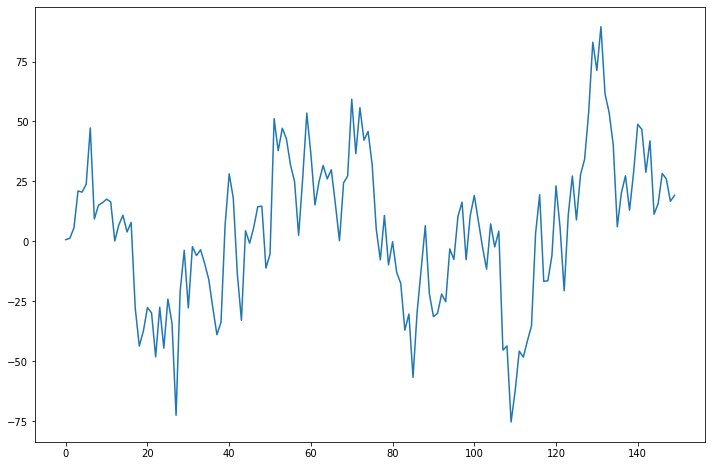

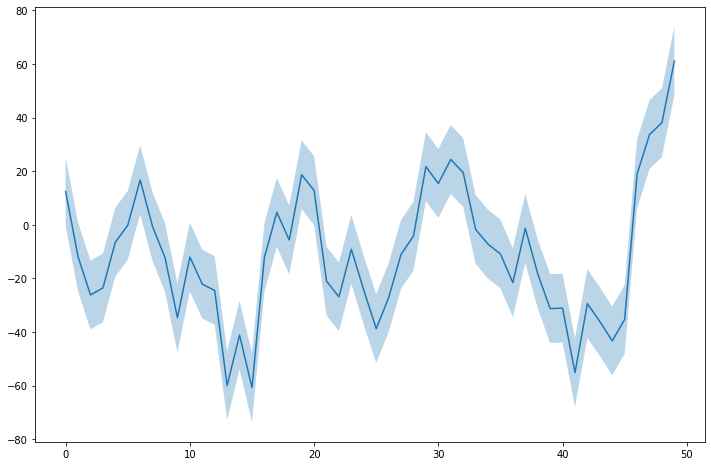

In [182]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_posterior_mean)
# ax.plot(dynamax_posterior_mean)
ax.fill_between(jnp.arange(150),
                 tfp_posterior_mean-2*tfp_posterior_scale,
                 tfp_posterior_mean+2*tfp_posterior_scale,
                 alpha=0.3)
# ax.fill_between(jnp.arange(150),
                #  dynamax_posterior_mean-2*jnp.sqrt(dynamax_posterior_cov),
                #  dynamax_posterior_mean+2*jnp.sqrt(dynamax_posterior_cov),
                #  alpha=0.3)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_forecast_mean)
# ax.plot(dynamax_forecast_mean)
ax.fill_between(jnp.arange(50),
                 tfp_forecast_mean-2*tfp_forecast_scale,
                 tfp_forecast_mean+2*tfp_forecast_scale,
                 alpha=0.3)
# ax.fill_between(jnp.arange(50),
                #  dynamax_forecast_mean-2*jnp.sqrt(dynamax_forecast_cov),
                #  dynamax_forecast_mean+2*jnp.sqrt(dynamax_forecast_cov),
                #  alpha=0.3)

Test SeasonalDummy forecast.

In [158]:
def _build_models(time_steps, key):

    keys = jr.split(key, 5)
    standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

    # Generate parameters of the STS component
    num_seasons = 5
    drift_scale = 0.2
    obs_noise_scale = 1.

    # Generate observed time series using the SSM representation.
    # num_seasons = 5, so dim_of_state = 4.
    F = jnp.array([[-1, -1, -1, -1],
                   [ 1,  0,  0,  0],
                   [ 0,  1,  0,  0],
                   [ 0,  0,  1,  0]])

    H = jnp.array([[1, 0, 0, 0]])

    Q = drift_scale * jnp.array([[1, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0],
                                 [0, 0, 0, 0]])
    R = obs_noise_scale

    def _step(current_state, key):
        key1, key2 = jr.split(key)
        current_obs = H @ current_state + R * standard_mvn.sample(seed=key1)
        next_state = F @ current_state + Q @ MVN(jnp.zeros(4), jnp.eye(4)).sample(seed=key2)
        return next_state, current_obs

    initial_state = jnp.array([8., 4., 0., -4.])
    key_seq = jr.split(keys[2], time_steps)
    _, obs_time_series = lax.scan(_step, initial_state, key_seq)

    # Build the STS model using tfp module.
    tfp_comp = tfp.sts.Seasonal(num_seasons, observed_time_series=obs_time_series,
                                name='seasonal_dummy')
    tfp_model = tfp.sts.Sum([tfp_comp], observed_time_series=obs_time_series, constant_offset=0.)

    # Build the dynamax STS model.
    dynamax_comp = SeasonalDummy(num_seasons, name='seasonal_dummy')
    dynamax_model = STS([dynamax_comp], obs_time_series=obs_time_series)

    # Set the parameters to the parameters learned by the tfp module and fix the parameters.
    tfp_vi_posterior = tfp.sts.build_factored_surrogate_posterior(tfp_model)
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=tfp_model.joint_distribution(obs_time_series).log_prob,
        surrogate_posterior=tfp_vi_posterior,
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        num_steps=200,
        jit_compile=True)
    vi_dists, _ = tfp_vi_posterior.distribution.sample_distributions()
    tfp_params = tfp_vi_posterior.sample(sample_shape=(1,))

    dynamax_model.params['seasonal_dummy']['drift_cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['seasonal_dummy/_drift_scale']**2))
    dynamax_model.params['obs_model']['cov'] =\
        jnp.atleast_2d(jnp.array(tfp_params['observation_noise_scale']**2))

    return (tfp_model, tfp_params,
            dynamax_model, dynamax_model.params,
            obs_time_series,
            vi_dists)


def test_seasonal_dummy_forecast(time_steps=150, key=jr.PRNGKey(3)):

    tfp_model, tfp_params, dynamax_model, dynamax_params, obs_time_series, vi_dists =\
        _build_models(time_steps, key)

    # Fit and forecast with the tfp module.
    # Not use tfp.sts.decmopose_by_component() since its output series is centered at 0.
    masked_time_series = tfp.sts.MaskedTimeSeries(time_series=obs_time_series,
                                                  is_missing=tf.math.is_nan(obs_time_series))
    tfp_posterior = tfp.sts.impute_missing_values(tfp_model, masked_time_series, tfp_params,
                                                  include_observation_noise=False)
    tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                     parameter_samples=tfp_params,
                                     num_steps_forecast=50,
                                     include_observation_noise=True)
    tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
    tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
    tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
    tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

    # Fit and forecast with dynamax
    dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                             obs_time_series)
    dynamax_forecast = dynamax_model.forecast(dynamax_params, obs_time_series,
                                              num_forecast_steps=50)
    dynamax_posterior_mean = dynamax_posterior['seasonal_dummy']['pos_mean'].squeeze()
    dynamax_posterior_cov = dynamax_posterior['seasonal_dummy']['pos_cov'].squeeze()
    dynamax_forecast_mean = dynamax_forecast['means'].squeeze()
    dynamax_forecast_cov = dynamax_forecast['covariances'].squeeze()

    # Compare posterior inference by tfp and dynamax.
    # In comparing the smoothed posterior, we omit the first 5 time steps,
    # since the tfp and the dynamax implementations of STS has different settings in
    # distributions of initial state, which will influence the posterior inference of
    # the first few states.
    len_step = jnp.abs(tfp_posterior_mean[1:]-tfp_posterior_mean[:-1]).mean()
    assert jnp.allclose(tfp_posterior_mean[5:], dynamax_posterior_mean[5:], atol=0.2*len_step)
    assert jnp.allclose(tfp_posterior_scale[5:], jnp.sqrt(dynamax_posterior_cov)[5:], rtol=3e-1)
    # Compoare forecast by tfp and dynamax.
    assert jnp.allclose(tfp_forecast_mean, dynamax_forecast_mean, atol=0.1*len_step)
    assert jnp.allclose(jnp.sqrt(dynamax_forecast_cov), tfp_forecast_scale, rtol=3e-1)

In [107]:
time_steps=150
key=jr.PRNGKey(2)

tfp_model, tfp_params, dynamax_model, dynamax_params, obs_time_series, vi_dists =\
        _build_models(time_steps, key)

# Fit and forecast with the tfp module.
# Not use tfp.sts.decmopose_by_component() since its output series is centered at 0.
masked_time_series = tfp.sts.MaskedTimeSeries(time_series=obs_time_series,
                                              is_missing=tf.math.is_nan(obs_time_series))
tfp_posterior = tfp.sts.impute_missing_values(tfp_model, masked_time_series, tfp_params,
                                              include_observation_noise=False)
tfp_forecasts = tfp.sts.forecast(tfp_model, obs_time_series,
                                 parameter_samples=tfp_params,
                                 num_steps_forecast=50,
                                 include_observation_noise=True)
tfp_posterior_mean = jnp.array(tfp_posterior.mean()).squeeze()
tfp_posterior_scale = jnp.array(jnp.array(tfp_posterior.stddev())).squeeze()
tfp_forecast_mean = jnp.array(tfp_forecasts.mean()).squeeze()
tfp_forecast_scale = jnp.array(tfp_forecasts.stddev()).squeeze()

# Fit and forecast with dynamax
dynamax_posterior = dynamax_model.decompose_by_component(dynamax_params,
                                                         obs_time_series)
dynamax_forecast = dynamax_model.forecast(dynamax_params, obs_time_series,
                                          num_forecast_steps=50)
dynamax_posterior_mean = dynamax_posterior['seasonal_dummy']['pos_mean'].squeeze()
dynamax_posterior_cov = dynamax_posterior['seasonal_dummy']['pos_cov'].squeeze()
dynamax_forecast_mean = dynamax_forecast['means'].squeeze()
dynamax_forecast_cov = dynamax_forecast['covariances'].squeeze()

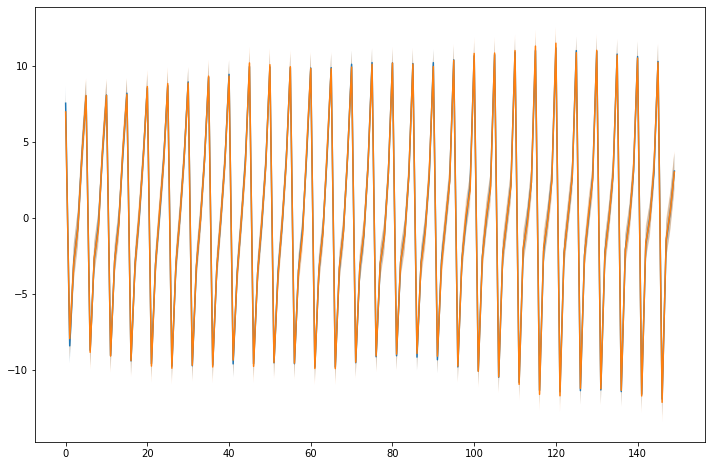

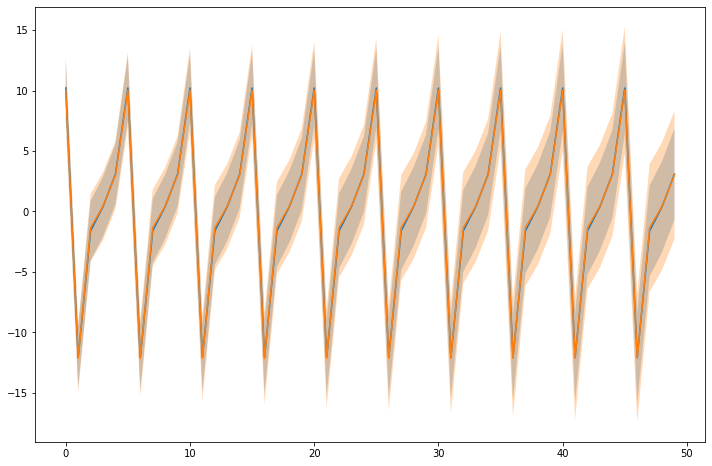

In [108]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_posterior_mean)
ax.plot(dynamax_posterior_mean)
ax.fill_between(jnp.arange(150),
                 tfp_posterior_mean-2*tfp_posterior_scale,
                 tfp_posterior_mean+2*tfp_posterior_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(150),
                 dynamax_posterior_mean-2*jnp.sqrt(dynamax_posterior_cov),
                 dynamax_posterior_mean+2*jnp.sqrt(dynamax_posterior_cov),
                 alpha=0.3)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(tfp_forecast_mean)
ax.plot(dynamax_forecast_mean)
ax.fill_between(jnp.arange(50),
                 tfp_forecast_mean-2*tfp_forecast_scale,
                 tfp_forecast_mean+2*tfp_forecast_scale,
                 alpha=0.3)
ax.fill_between(jnp.arange(50),
                 dynamax_forecast_mean-2*jnp.sqrt(dynamax_forecast_cov),
                 dynamax_forecast_mean+2*jnp.sqrt(dynamax_forecast_cov),
                 alpha=0.3)

Test SeasonalTrig component

In [12]:
keys = jr.split(key, 5)
standard_mvn = MVN(jnp.zeros(1), jnp.eye(1))

# Generate parameters of the STS component
num_seasons = 5
drift_scale = 0.2
obs_noise_scale = 2.

# Generate observed time series using the SSM representation.
# num_seasons = 5, so dim_of_state = 4.
cos = lambda j: jnp.cos(2*jnp.pi*j/jnp.floor(num_seasons/2))
sin = lambda j: jnp.sin(2*jnp.pi*j/jnp.floor(num_seasons/2))

F = jnp.array([[ cos(1), sin(1),     0,      0],
               [-sin(1), cos(1),     0,      0],
               [     0,      0,  cos(2), sin(2)],
               [     0,      0, -sin(2), cos(2)]])

H = jnp.array([[1, 0, 1, 0]])

Q = drift_scale * jnp.eye(num_seasons-1)
R = obs_noise_scale

def _step(current_state, key):
    key1, key2 = jr.split(key)
    current_obs = H @ current_state + R * standard_mvn.sample(seed=key1)
    next_state = F @ current_state + Q @ MVN(jnp.zeros(4), jnp.eye(4)).sample(seed=key2)
    return next_state, (H @ current_state, current_obs)

initial_state = jnp.array([8., 4., 0., -4.])
key_seq = jr.split(keys[2], time_steps)
_, (obs_mean, obs_time_series) = lax.scan(_step, initial_state, key_seq)

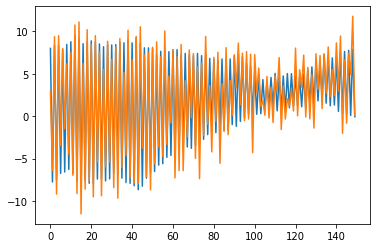

In [13]:
plt.plot(obs_mean)
plt.plot(obs_time_series)